# Importación de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
import nltk
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier


# Carga de datos y Preprocesamiento

Importamos el dataset de entrenamiento

In [7]:
df = pd.read_csv("./train_normalizado_lematizacion.csv")

ds_trabajo = df.copy()
ds_trabajo.head(5)

,ID,review_es,sentimiento
0,0,uno de el otro crítico haber mencionar que des...,positivo
1,1,uno pequeño pequeño producción el técnica de f...,positivo
2,2,pensar que este ser uno manera maravilloso de ...,positivo
3,3,básicamente haber uno familia donde uno niño...,negativo
4,4,el amor en el tiempo de petter mattei ser ...,positivo


Creamos una función para mostrar las métricas y la matriz de confusión de nuestras predicciones.

In [8]:
def mostrar_metricas(y_test, y_pred):
    print("La accuracy es {}".format(accuracy_score(y_test, y_pred)))
    print("La precision es {}".format(precision_score(y_test, y_pred, average='macro')))
    print("El recall es {}".format(recall_score(y_test, y_pred, average='macro')))
    print("El F1 es {}".format(f1_score(y_test, y_pred, average='macro')))

    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
    plt.xlabel('Valores Predicción')
    plt.ylabel('Valores Reales')

Obtenemos las stopwords en español de la bibliotecta nltk para eliminarlas de los textos posteriormente.

In [9]:
stopwords = nltk.corpus.stopwords.words('spanish')

Vamos a aplicar las técnicas de lemmatización y stemming para reducir la cantidad y la complejidad de las palabras en los textos, generando dos datasets distintos con estos preprocesamientos para utilizar a lo largo del trabajo. 

Nota: vamos a dejar los preprocesamientos aplicados comentados y los guardaremos en los csv `train_normalizado_lematizacion.csv` y `train_normalizado_stemming.csv`. Vamos a hacer lo mismo para `test.csv`.

In [20]:
## Aplicamos lemmatizacion
# import re
# ds_trabajo.review_es = ds_trabajo.review_es.str.lower();
# ds_trabajo.review_es = ds_trabajo.review_es.apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
# ds_trabajo.review_es

In [21]:
# nlp = spacy.load('es_core_news_sm')

# # Realizar la lematización en la columna 'Texto'
# ds_trabajo.review_es = ds_trabajo.review_es.apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))

# print(ds_trabajo.review_es)

In [22]:
## Aplicamos stemming
# from nltk.stem import SnowballStemmer

# stemmer = SnowballStemmer('spanish')

# ds_trabajo.review_es = ds_trabajo.review_es.apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# print(ds_trabajo.review_es)

# Modelo 1: Bayes Naïve con CountVectorizer

Como primer modelo vamos a probar Bayes Naïve tokenizando con CountVectorizer y eliminando las stopwords. Usaremos un clasificador multinomial y técnica de Laplace Smoothing con alpha = 1.

In [37]:
preprocesador = CountVectorizer(stop_words=stopwords)

textos_entrenamiento, textos_prueba, etiquetas_entrenamiento, etiquetas_prueba = train_test_split(ds_trabajo.review_es, ds_trabajo.sentimiento, test_size=0.2, random_state=42)

vectorizador = preprocesador.fit(textos_entrenamiento)
caracteristicas_entrenamiento = vectorizador.transform(textos_entrenamiento)
caracteristicas_prueba = vectorizador.transform(textos_prueba)

modelo = MultinomialNB(alpha=1)
modelo.fit(caracteristicas_entrenamiento, etiquetas_entrenamiento)

predicciones = modelo.predict(caracteristicas_prueba)



Observamos que las métricas dan todas similares, cercanas al 83%.

La accuracy es 0.8366
La precision es 0.8383409388641156
El recall es 0.8368786756986295
El F1 es 0.8364605597316497


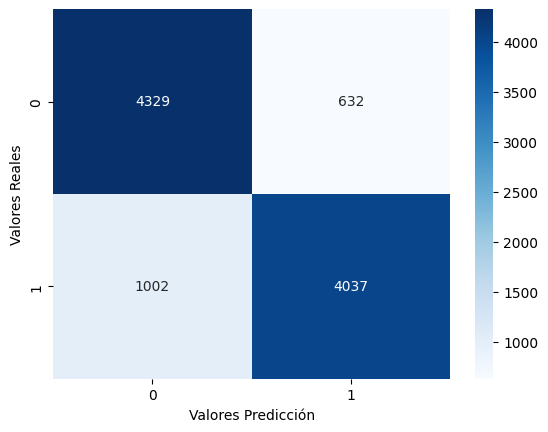

In [38]:
mostrar_metricas(etiquetas_prueba, predicciones)

Exportamos el modelo en formato pickle.

In [39]:
# import pickle

# with open('./models/naive_bayes/nb_model.pickle', 'wb') as archivo:
#     pickle.dump(modelo, archivo)

In [40]:
# with open('./models/naive_bayes/nb_model.pickle', 'rb') as archivo:
#     modelo_cargado = pickle.load(archivo)

# ds_test = pd.read_csv('./test_normalizado_stemming.csv')
# ds_submission = ds_test.copy()

# nuevas_caracteristicas = vectorizador.transform(ds_submission.review_es)
# predicciones_nuevas = modelo_cargado.predict(nuevas_caracteristicas)

# df_submission = pd.DataFrame({'ID': ds_submission.ID, 'sentimiento': predicciones_nuevas})
# df_submission.head()
# df_submission.to_csv('submissions/naive_bayes/nb_submission.csv', index=False)

Observación: este modelo overfitteó. Obtuvimos buenas métricas en entrenamiento, pero malas métricas en la submission de Kaggle.

# Modelo 2: Bayes Naïve con TfidfVectorizer

Vamos a entrenar un segundo modelo Bayes Naïve, esta vez utilizando valores normalizados, computando la frecuencia inversa de cada término con TfidfVectorizer.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(ds_trabajo.review_es, ds_trabajo.sentimiento, test_size=0.2, random_state=42)

# Crear un objeto TfidfVectorizer con stopwords en español
vectorizador = TfidfVectorizer(stop_words=stopwords)

# Ajustar y transformar los datos de entrenamiento
X_train_transformado = vectorizador.fit_transform(X_train)

# Transformar los datos de prueba
X_test_transformado = vectorizador.transform(X_test)

# Crear el modelo Naive Bayes Multinomial
modelo_2 = MultinomialNB()

# Entrenar el modelo con los datos de entrenamiento
modelo_2.fit(X_train_transformado, y_train)

MultinomialNB()

Observando las métricas, estas dieron un poco más altas que con CountVectorizer, cercanas al 85%.

La accuracy es 0.8513
La precision es 0.8513656195860417
El recall es 0.8513572565754901
El F1 es 0.8512999271369643


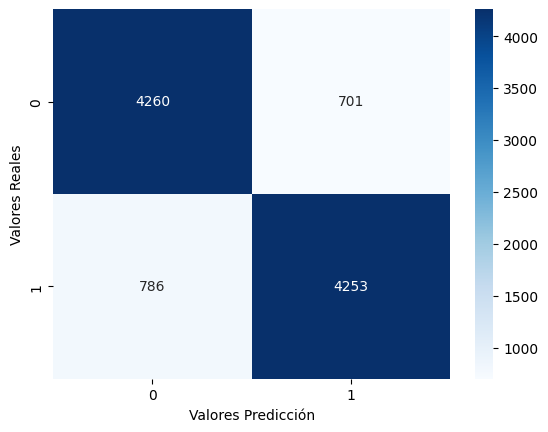

In [63]:
y_pred = modelo_2.predict(X_train_transformado)
mostrar_metricas(y_test, predicciones)

Exportamos el modelo en formato pickle.

In [43]:
# import pickle

# with open('./models/naive_bayes/nb_model2.pickle', 'wb') as archivo:
#     pickle.dump(modelo_2, archivo)

In [44]:
# with open('./models/naive_bayes/nb_model2.pickle', 'rb') as archivo:
#     modelo_cargado = pickle.load(archivo)

# ds_test = pd.read_csv('./test_normalizado_stemming.csv')
# ds_submission = ds_test.copy()

# nuevas_caracteristicas = vectorizador.transform(ds_submission.review_es)
# predicciones_nuevas = modelo_cargado.predict(nuevas_caracteristicas)

# df_submission = pd.DataFrame({'ID': ds_submission.ID, 'sentimiento': predicciones_nuevas})
# df_submission.head()
# df_submission.to_csv('submissions/naive_bayes/nb_submission2.csv', index=False)

Nota: este modelo también overfitteó al hacer las predicciones en Kaggle (dio 85% en train y 71% en test, aproximadamente).

## Optimización de hiperparámetros

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(ds_trabajo.review_es, ds_trabajo.sentimiento, test_size=0.2, random_state=42)

# Crear un objeto TfidfVectorizer con stopwords en español
vectorizador = TfidfVectorizer(stop_words=stopwords)

# Ajustar y transformar los datos de entrenamiento
X_train_transformado = vectorizador.fit_transform(X_train)

# Transformar los datos de prueba
X_test_transformado = vectorizador.transform(X_test)

# Definir los hiperparámetros a ajustar
parametros = {
    'alpha': np.arange(0, 1.2, 0.2),
    'fit_prior': [True, False]
}

# Crear el modelo Naive Bayes Multinomial
modelo = MultinomialNB()

# Realizar la búsqueda en cuadrícula
grid_search = GridSearchCV(modelo, parametros, cv=5)
grid_search.fit(X_train_transformado, y_train)

# Obtener los mejores hiperparámetros y el mejor modelo
mejores_hiperparametros = grid_search.best_params_
mejor_modelo = grid_search.best_estimator_

# Evaluar el mejor modelo en los datos de prueba
predicciones = mejor_modelo.predict(X_test_transformado)
exactitud = accuracy_score(y_test, predicciones)

print("Mejores hiperparámetros:", mejores_hiperparametros)
print("Exactitud del mejor modelo:", exactitud)

c:\Users\franco.patiño\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
c:\Users\franco.patiño\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
c:\Users\franco.patiño\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
c:\Users\franco.patiño\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10.

Mejores hiperparámetros: {'alpha': 0.8, 'fit_prior': False}
Exactitud del mejor modelo: 0.8432


In [65]:
X_train, X_test, y_train, y_test = train_test_split(ds_trabajo.review_es, ds_trabajo.sentimiento, test_size=0.2, random_state=42)

# Crear un objeto TfidfVectorizer con stopwords en español
vectorizador = TfidfVectorizer(stop_words=stopwords)

# Ajustar y transformar los datos de entrenamiento
X_train_transformado = vectorizador.fit_transform(X_train)

# Transformar los datos de prueba
X_test_transformado = vectorizador.transform(X_test)

# Crear el modelo Naive Bayes Multinomial
modelo_2 = MultinomialNB(alpha=0.8, fit_prior=False)

# Entrenar el modelo con los datos de entrenamiento
modelo_2.fit(X_train_transformado, y_train)

MultinomialNB(alpha=0.8, fit_prior=False)

La accuracy es 0.8432
La precision es 0.843347333228267
El recall es 0.8432825053076229
El F1 es 0.8431974911598585


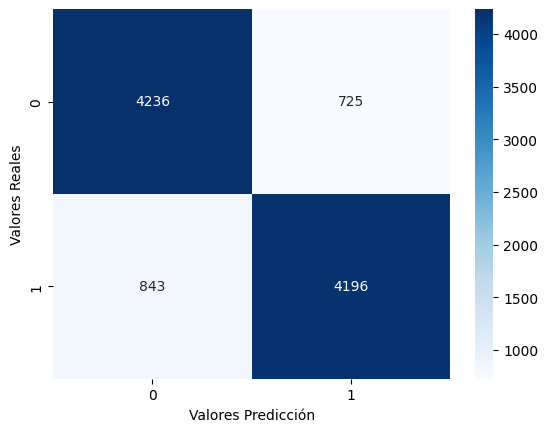

In [66]:
y_pred = modelo_2.predict(X_test_transformado)
mostrar_metricas(y_test, y_pred)

Observación: optimizamos hiperparámetros para el dataset radicalizado, lematizado y sin preprocesamientos, y no obtuvimos muy buenos resultados. Los tres modelos sobreajustaron. 

# Random Forest (optimización con Random Search)

Empezamos creando un modelo Random Forest por default y observamos las métricas obtenidas

In [10]:
X_train, X_test, y_train, y_test = train_test_split(ds_trabajo.review_es, ds_trabajo.sentimiento, test_size=0.2, random_state=42)

vectorizador = TfidfVectorizer(stop_words=stopwords)

X_train_transformado = vectorizador.fit_transform(X_train)

X_test_transformado = vectorizador.transform(X_test)


modelo_rf = RandomForestClassifier()
modelo_rf.fit(X_train_transformado, y_train)

y_pred = modelo_rf.predict(X_test_transformado)

La accuracy es 0.8334
La precision es 0.8334744746843461
El recall es 0.8334600677105195
El F1 es 0.8333997600956546


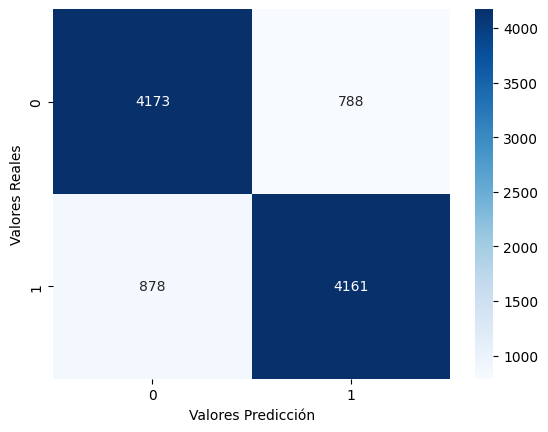

In [11]:
mostrar_metricas(y_test, y_pred)

TODO: hacer el train test split una única vez

Observamos que los conjuntos luego del split quedaron balanceados.

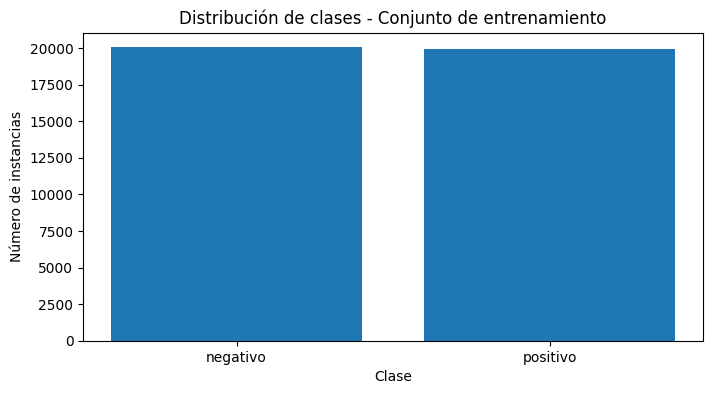

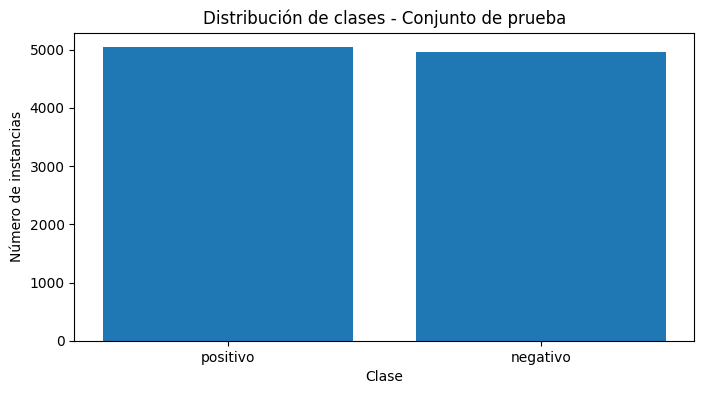

In [12]:
import matplotlib.pyplot as plt

train_class_counts = pd.Series(y_train).value_counts()
test_class_counts = pd.Series(y_test).value_counts()

# Visualización del conjunto de entrenamiento
plt.figure(figsize=(8, 4))
plt.bar(train_class_counts.index, train_class_counts.values)
plt.title('Distribución de clases - Conjunto de entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Número de instancias')
plt.show()

# Visualización del conjunto de prueba
plt.figure(figsize=(8, 4))
plt.bar(test_class_counts.index, test_class_counts.values)
plt.title('Distribución de clases - Conjunto de prueba')
plt.xlabel('Clase')
plt.ylabel('Número de instancias')
plt.show()

Aplicamos Random Search para buscar los mejores hiperparámetros de un modelo Random Forest.
Nota: vamos a estar realizando de a 10 iteraciones por búsqueda para llegar a resultados, intentando con Grid Search tardó demasiado y no logramos terminar de correrlo. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

parametros = {
    'n_estimators': [80, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 4],
}


X_train, X_test, y_train, y_test = train_test_split(ds_trabajo.review_es, ds_trabajo.sentimiento, test_size=0.7, random_state=42)
vectorizador = TfidfVectorizer(stop_words=stopwords)
X_train_transformado = vectorizador.fit_transform(X_train)
X_test_transformado = vectorizador.transform(X_test)

random_search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=parametros, scoring='f1', n_iter=10, cv=7)
random_search.fit(X_train_transformado, y_train)

mejores_parametros = random_search.best_params_
mejor_puntaje = random_search.best_score_

mejor_modelo = random_search.best_estimator_

mejor_modelo.score(X_test_transformado, y_test)

C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
           ^^^^^^^^^^^^
  File "C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fil

0.8089714285714286

Obtenemos la mejor combinación de hiperparámetros lograda en esta iteración.

In [ ]:
random_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_depth': 10}

Observamos las métricas para el mejor modelo de la iteración.

La accuracy es 0.8089714285714286
La precision es 0.8120370040559348
El recall es 0.8090194867155319
El F1 es 0.8085175579735617


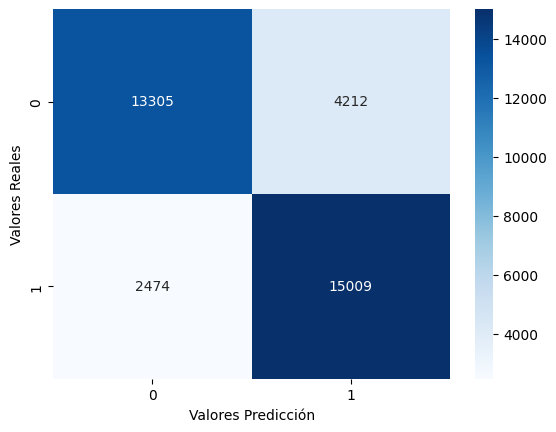

In [ ]:
y_pred = mejor_modelo.predict(X_test_transformado)

mostrar_metricas(y_test, y_pred)

In [ ]:
# import pickle

# with open('./models/random_forest/rf_model3.pickle', 'wb') as archivo:
#     pickle.dump(mejor_modelo, archivo)

In [ ]:
# with open('./models/random_forest/rf_model3.pickle', 'rb') as archivo:
#     modelo_cargado = pickle.load(archivo)

# ds_test = pd.read_csv('./test_normalizado_lematizacion.csv')
# ds_submission = ds_test.copy()

# nuevas_caracteristicas = vectorizador.transform(ds_submission.review_es)
# predicciones_nuevas = modelo_cargado.predict(nuevas_caracteristicas)

# df_submission = pd.DataFrame({'ID': ds_submission.ID, 'sentimiento': predicciones_nuevas})
# df_submission.head()
# df_submission.to_csv('submissions/random_forest/rf_submission3.csv', index=False)

La mejor que obtuvimos de 2: 82% aprox. todo en entrenamiento, 72% en test con el dataset original y con 
{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 20}

Estas son las metricas de ese modelo en train, es el que es 0.72804 en kaggle:
La accuracy es 0.8205
La precision es 0.8216906233847056
El recall es 0.8202574044604873
El F1 es 0.8202472226568611